In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("dns_logs_sample.csv")
df.head()

,timestamp,source_ip,destination_ip,domain_name,query_type,response_code,is_malicious
0,2023-07-20 02:00:00,192.168.1.70,10.0.0.107,malicious.site,CNAME,1,1
1,2023-07-20 12:28:00,192.168.1.193,10.0.0.253,tracker.org,A,0,0
2,2023-07-20 23:35:00,192.168.1.248,10.0.0.196,example.com,TXT,1,0
3,2023-07-20 05:45:00,192.168.1.88,10.0.0.246,safe.net,A,5,0
4,2023-07-20 22:49:00,192.168.1.114,10.0.0.239,safe.net,MX,0,0


In [7]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=["query_type", "domain_name"])

# Drop unnecessary fields
df_encoded.drop(["timestamp", "source_ip", "destination_ip"], axis=1, inplace=True)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split data
X = df_encoded.drop("is_malicious", axis=1)
y = df_encoded["is_malicious"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Results
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[18  0]
 [ 0 22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        22

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [11]:
from sklearn.ensemble import IsolationForest

# Isolation Forest for anomaly detection
iso_model = IsolationForest(contamination=0.1)
df['anomaly_score'] = iso_model.fit_predict(X)

# -1 means anomaly
df['is_anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)
df[['timestamp', 'domain_name', 'is_anomaly']].head()

,timestamp,domain_name,is_anomaly
0,2023-07-20 02:00:00,malicious.site,0
1,2023-07-20 12:28:00,tracker.org,0
2,2023-07-20 23:35:00,example.com,0
3,2023-07-20 05:45:00,safe.net,0
4,2023-07-20 22:49:00,safe.net,0


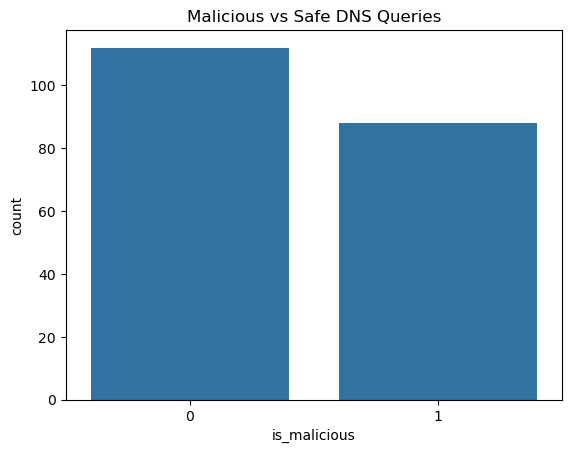

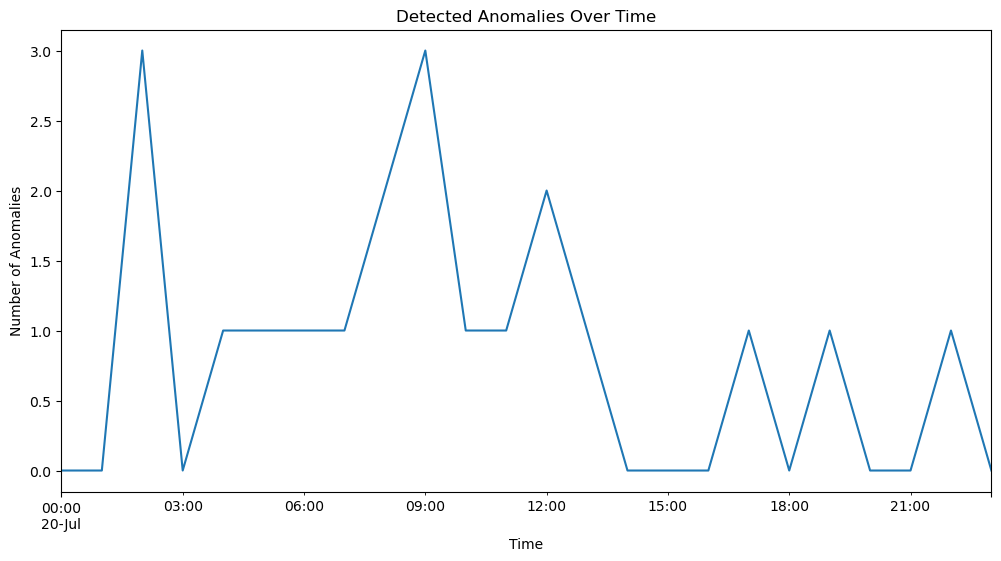

In [15]:
# Malicious domain counts
sns.countplot(x="is_malicious", data=df)
plt.title("Malicious vs Safe DNS Queries")
plt.show()

# Anomalies over time (fixed warning by using 'h' instead of 'H')
plt.figure(figsize=(12, 6))
df.set_index("timestamp")['is_anomaly'].resample('h').sum().plot()
plt.title("Detected Anomalies Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Anomalies")
plt.show()